In [11]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', ' [LINK] ', text)
    text = re.sub(r'\S+@\S+', ' [EMAIL] ', text)
    text = re.sub(r'\d+', ' [NUMBER] ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

def get_stats(text):
    stats = {}
    stats['msg_length'] = len(text)
    stats['word_count'] = len(text.split())
    stats['capital_ratio'] = sum(1 for c in text if c.isupper()) / (len(text)+1)
    stats['excl_count'] = text.count('!')
    stats['digit_count'] = sum(1 for c in text if c.isdigit())
    spam_words = ['free', 'win', 'winner', 'cash', 'prize', 'urgent', 'claim']
    stats['spam_word_count'] = sum([text.lower().count(word) for word in spam_words])
    return pd.Series(stats)

# Veri yükle
sms_spam_path = "data/spam.csv"
sms_df = pd.read_csv(sms_spam_path, encoding='latin1')
if set(['label', 'message']).issubset(sms_df.columns):
    sms_df = sms_df[['message', 'label']].dropna()
elif set(['v1', 'v2']).issubset(sms_df.columns):
    sms_df = sms_df.rename(columns={'v1': 'label', 'v2': 'message'})
else:
    raise ValueError("SMS Spam datasetinde beklenen sütunlar yok.")

# Temizleme ve etiket
sms_df['clean_text'] = sms_df['message'].apply(clean_text)
sms_df = sms_df[sms_df['clean_text'].str.strip() != ''].reset_index(drop=True)
sms_df['label_num'] = sms_df['label'].map({'ham': 0, 'spam': 1})
stats_df = sms_df['message'].apply(get_stats)
sms_df = pd.concat([sms_df, stats_df], axis=1)
display(sms_df.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yiit_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yiit_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yiit_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,label,message,Unnamed: 2,Unnamed: 3,Unnamed: 4,clean_text,label_num,msg_length,word_count,capital_ratio,excl_count,digit_count,spam_word_count
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,go jurong point crazy available bugis n great ...,0,111.0,20.0,0.026786,0.0,0.0,0.0
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,ok lar joking wif u oni,0,29.0,6.0,0.066667,0.0,0.0,0.0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,free entry NUMBER wkly comp win fa cup final t...,1,155.0,28.0,0.064103,0.0,25.0,2.0
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,u dun say early hor u c already say,0,49.0,11.0,0.040000,0.0,0.0,0.0
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,nah dont think go usf life around though,0,61.0,13.0,0.032258,0.0,0.0,0.0


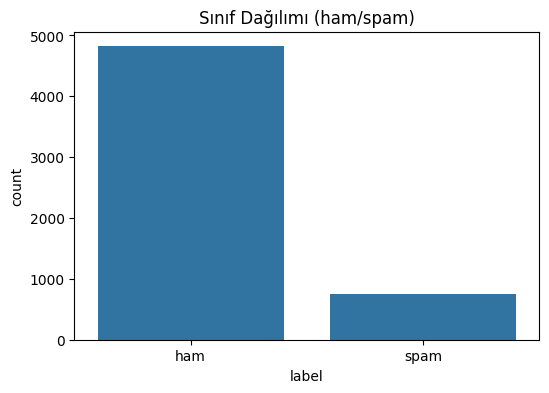

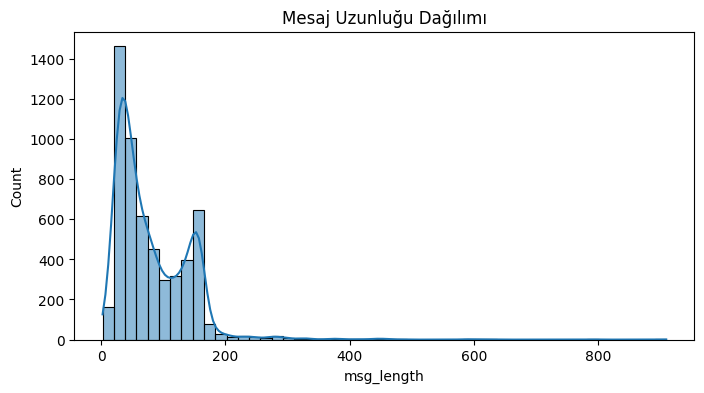

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=sms_df)
plt.title("Sınıf Dağılımı (ham/spam)")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(sms_df['msg_length'], bins=50, kde=True)
plt.title("Mesaj Uzunluğu Dağılımı")
plt.show()


In [13]:
def prepare_features(df):
    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
    X_tfidf = tfidf.fit_transform(df['clean_text'])
    extra_features = df[['msg_length', 'word_count', 'capital_ratio', 'excl_count', 'digit_count', 'spam_word_count']].values
    X = hstack([X_tfidf, extra_features])
    y = df['label_num'].values
    # Kaydet (test için gerekecek)
    if not os.path.exists("models"):
        os.makedirs("models")
    joblib.dump(tfidf, "models/sms_tfidf_vectorizer.pkl")
    return X, y, tfidf

X_sms, y_sms, tfidf_sms = prepare_features(sms_df)
X_train, X_test, y_train, y_test = train_test_split(X_sms, y_sms, test_size=0.2, stratify=y_sms, random_state=42)
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)


In [14]:
models_params = {
    'RandomForest': (RandomForestClassifier(random_state=42), {'n_estimators':[200], 'max_depth':[None]}),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {'n_estimators':[100], 'learning_rate':[1.0]}),
    'MLP': (MLPClassifier(random_state=42, max_iter=200), {'hidden_layer_sizes':[(100,50)], 'activation':['relu'], 'learning_rate_init':[0.001]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors':[3]}),
    'LinearSVC': (LinearSVC(random_state=42, max_iter=3000), {'C':[10]})
}

best_estimators = {}
for name, (model, params) in models_params.items():
    print(f"Model: {name}")
    grid = GridSearchCV(model, params, cv=2, n_jobs=-1, scoring='f1')
    grid.fit(X_train_bal, y_train_bal)
    print("Best params:", grid.best_params_)
    best_estimators[name] = grid.best_estimator_
    y_pred = grid.predict(X_test)
    print(classification_report(y_test, y_pred))
    joblib.dump(grid.best_estimator_, f"models/sms_{name}.pkl")


Model: RandomForest
Best params: {'max_depth': None, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       965
           1       0.99      0.91      0.94       149

    accuracy                           0.99      1114
   macro avg       0.99      0.95      0.97      1114
weighted avg       0.99      0.99      0.99      1114

Model: AdaBoost
Best params: {'learning_rate': 1.0, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       965
           1       0.87      0.92      0.90       149

    accuracy                           0.97      1114
   macro avg       0.93      0.95      0.94      1114
weighted avg       0.97      0.97      0.97      1114

Model: MLP
Best params: {'activation': 'relu', 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001}
              precision    recall  f1-score   support

           0       0.99      1.00  

In [15]:
ensemble = VotingClassifier(
    estimators=[(name, est) for name, est in best_estimators.items()],
    voting='hard'
)
ensemble.fit(X_train_bal, y_train_bal)
y_pred_ensemble = ensemble.predict(X_test)
print("\nEnsemble (Voting) Model Sonucu:")
print(classification_report(y_test, y_pred_ensemble))
joblib.dump(ensemble, "models/sms_ensemble.pkl")



Ensemble (Voting) Model Sonucu:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       965
           1       0.98      0.92      0.95       149

    accuracy                           0.99      1114
   macro avg       0.98      0.96      0.97      1114
weighted avg       0.99      0.99      0.99      1114



['models/sms_ensemble.pkl']

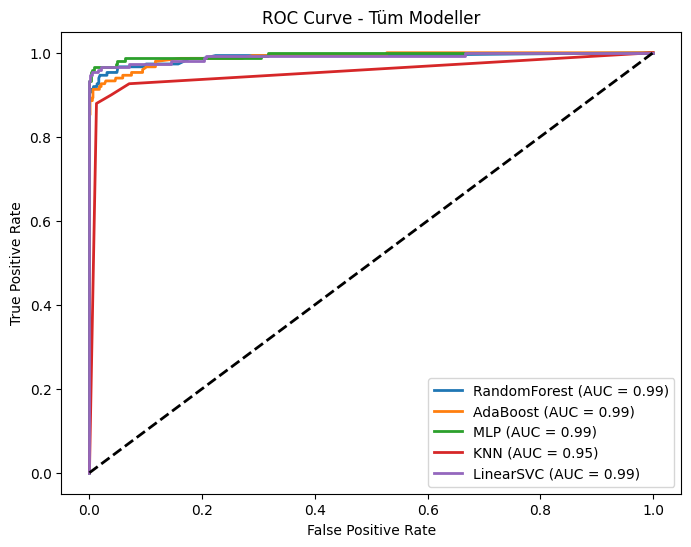

In [16]:
plt.figure(figsize=(8,6))
for name, model in best_estimators.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:,1]
    else:
        try:
            y_score = model.decision_function(X_test)
        except:
            y_score = None
    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tüm Modeller')
plt.legend()
plt.show()
